##### Import

In [1]:
import warnings
import papermill as pm
import scrapbook as sb
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from tqdm import tqdm
import shap
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.pipeline import Pipeline
import os
import gc
import sys

# Filter out warning messages
warnings.filterwarnings('ignore')

# Set pandas display options
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# Set seaborn style
sns.set_style('whitegrid')

# Add the parent directory to sys.path
sys.path.insert(1, os.path.join(sys.path[0], '..'))

# Index and deciles for data slicing
idx = pd.IndexSlice

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# from pathlib import Path
# import pandas as pd
# from utils import rank_stocks_and_quantile
# # UNSEEN_KEY = '/data/YEAR_20220803_20230803'
# top = 250  # parameters -> papermill
# DATA_STORE = Path(f'data/{top}_dataset.h5')
# with pd.HDFStore(DATA_STORE) as store:
#     # unseen = store[UNSEEN_KEY]
#     print(store.keys())

In [3]:
from utils import rank_stocks_and_quantile

top = 250 # parameters -> papermill

DATA_STORE = Path(f'data/{top}_dataset.h5')
dataset_key = '/data/YEAR_20200930_20220802'
# dataset_key = None
target = 'TARGET_ret_fwd_01d' #'TARGET_ret_fwd_frac_order'
with pd.HDFStore(DATA_STORE) as store:
    dataset = store[dataset_key]
    # dataset = store['/data/YEAR_20161115_20181022']
    dataset = rank_stocks_and_quantile(dataset, TARGET_col=target)

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 117250 entries, (Timestamp('2020-09-30 00:00:00+0000', tz='UTC'), 'AA') to (Timestamp('2022-08-02 00:00:00+0000', tz='UTC'), 'ZTS')
Columns: 600 entries, FEATURE_open to TARGET_ret_fwd_01d_rank_quantiled
dtypes: float32(360), float64(32), int32(198), int64(1), int8(9)
memory usage: 280.6+ MB


In [5]:
# Define the features and label columns
features = [col for col in dataset.columns if col.startswith('FEATURE_')]
label = f'{target}_rank_quantiled'

# Print the number of features and the label
print(f"Number of features: {len(features)}")
print(f"Label: {label}")

# Remove timezone information from the date index
dataset.index.set_levels(dataset.index.levels[0].tz_localize(None), level=0, inplace=True)

### Since we have unseen dataset
# # Get unique dates and sort them
# unique_dates = dataset.index.get_level_values('date').unique().sort_values()

# # Define the look-ahead gap
# look_ahead = 1

# # Split dates for training and testing with a gap
# train_dates = unique_dates[:-21-look_ahead]
# test_dates = unique_dates[-21:]

# # Split the dataset using the train and test dates
# train_data = dataset[dataset.index.get_level_values('date').isin(train_dates)]
# test_data = dataset[dataset.index.get_level_values('date').isin(test_dates)]


Number of features: 586
Label: TARGET_ret_fwd_01d_rank_quantiled


In [6]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return pd.Series(fi / fi.sum(), index=model.feature_name())

def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    return 'ic', spearmanr(preds, train_data.get_label())[0], True

def sharpe_ratio_lgbm(preds, train_data):
    """Custom Sharpe ratio eval metric for lightgbm."""
    labels = train_data.get_label()
    if not isinstance(train_data.data.index, pd.MultiIndex):
        raise ValueError("Expecting a MultiIndex with date as the first level")

    grouped_labels = pd.Series(labels, index=train_data.data.index).groupby(level=0)
    grouped_preds = pd.Series(preds, index=train_data.data.index).groupby(level=0)

    daily_scores = []
    for (_, actuals_for_day), (_, preds_for_day) in zip(grouped_labels, grouped_preds):
        score_for_day = spearmanr(actuals_for_day, preds_for_day)[0]
        daily_scores.append(score_for_day if not np.isnan(score_for_day) else 0)

    sharpe_ratio = np.mean(daily_scores) / (np.std(daily_scores) + 1e-9)
    return 'sharpe_ratio', sharpe_ratio, True

def custom_eval_metrics(preds, train_data):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    labels = train_data.get_label()
    mae = mean_absolute_error(labels, preds)
    mse = mean_squared_error(labels, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(labels, preds)
    return [('MAE', mae, False), 
            ('MSE', mse, False), 
            ('RMSE', rmse, False), 
            ('R2', r2, True)]

def combined_eval_metrics(preds, train_data):
    ic_result = ic_lgbm(preds, train_data)
    sharpe_ratio_result = sharpe_ratio_lgbm(preds, train_data)
    custom_metrics_results = custom_eval_metrics(preds, train_data)
    return [ic_result, sharpe_ratio_result] + custom_metrics_results

In [7]:
def metrics_on_fold(era_scores, weights=None):
    era_scores = pd.Series(era_scores)
    
    # Calculate metrics
    mean_correlation = np.mean(era_scores)
    std_deviation = np.std(era_scores)
    sharpe_ratio = mean_correlation / std_deviation
    max_dd = (era_scores.cummax() - era_scores).max()

    # Smart Sharpe
    smart_sharpe = mean_correlation \
        / (std_deviation + np.std(era_scores.diff()))
    
    # Autocorrelation
    autocorrelation = era_scores.autocorr()

    metrics = pd.Series({
        'mean_correlation': mean_correlation,
        'std_deviation': std_deviation,
        'sharpe_ratio': sharpe_ratio,
        'smart_sharpe': smart_sharpe,
        'autocorrelation': autocorrelation,
        'max_dd': max_dd,
        'min_correlation': era_scores.min(),
        'max_correlation': era_scores.max(),
    })

    if weights:
        normalized_metrics = (metrics - metrics.min()) / (metrics.max() - metrics.min())
        weighted_values = normalized_metrics.multiply(pd.Series(weights))
        metrics["weighted_score"] = weighted_values.sum()

    _ = gc.collect()

    return metrics

In [8]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna
import mlflow
import mlflow.lightgbm
from optuna.integration import LightGBMPruningCallback
from scipy.stats import spearmanr
from utils import CustomBackwardMultipleTimeSeriesCV
import warnings

warnings.filterwarnings('ignore')

evals_result = {}

def get_categoricals(dataset, threshold):
    return [col for col in dataset.columns if \
            dataset[col].nunique() < threshold and \
            dataset[col].ge(0).all() and col.startswith("FEATURE_")]

def objective(trial, data, features, cv):
    # Dynamic categoricals based on the trial's suggested threshold
    cat_threshold = trial.suggest_int('cat_threshold', 5, 50)
    categoricals = [col for col in data.columns if data[col].nunique() < cat_threshold 
                    and data[col].ge(0).all() and col.startswith("FEATURE_")]

    params = {
        'boosting': 'gbdt',
        'objective': 'regression',
        'verbose': -1,
        'metric': 'None',
        'device': 'gpu',
        'num_leaves': trial.suggest_int('num_leaves', 30, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
    }

    early_stopping = lgb.early_stopping(stopping_rounds=500, \
        verbose=True, first_metric_only=True)
    daily_scores_in_fold = []

    for train_idx, val_idx in cv:
        train_features = data.loc[train_idx, features]
        train_labels = data.loc[train_idx, label]
        lgb_train = lgb.Dataset(data=train_features, label=train_labels, 
                        categorical_feature=categoricals, free_raw_data=False)

        val_features = data.loc[val_idx, features]
        val_labels = data.loc[val_idx, label]
        lgb_val = lgb.Dataset(data=val_features, label=val_labels, 
                categorical_feature=categoricals, free_raw_data=False)

        model = lgb.train(params=params,
                  train_set=lgb_train,
                  num_boost_round=5000,
                  valid_sets=[lgb_train, lgb_val],
                  valid_names=['train', 'valid_0'],
                  feval=combined_eval_metrics,   # Updated feval
                  callbacks=[lgb.record_evaluation(evals_result),
                             early_stopping,
                             LightGBMPruningCallback(trial, 'sharpe_ratio')])

        daily_scores_in_fold.extend(evals_result['valid_0']['sharpe_ratio'])

    weights = {
        'sharpe_ratio': 0.95,       # Primary objective, so highest weight
        'max_dd': -0.1,             # Major risk metric, negative to penalize higher drawdowns
        'autocorrelation': -0.1,    # Penalize strategies showing signs of overfitting
        # 'std_deviation': -0.025,    # Mild penalty for higher volatility 
        # 'smart_sharpe': 0.075       # Supplementary to Sharpe Ratio but considering autocorrelation
    }


    metrics = metrics_on_fold(daily_scores_in_fold, weights=weights)
    # score = metrics['sharpe_ratio']
    score = metrics["weighted_score"]
    # Log parameters, metrics, and evaluation results to MLflow
    with mlflow.start_run():
        mlflow.log_params(params)
        
        # Log metrics from metrics dictionary
        mlflow.log_metrics(metrics)
        
        # Logging each score and metric in evals_result
        for valid_set, metrics_dict in evals_result.items():
            for metric, values in metrics_dict.items():
                for idx, value in enumerate(values):
                    metric_name = f"{valid_set}_{metric}_{idx}"
                    mlflow.log_metric(metric_name, value)

        # Log the average sharpe ratio
        mlflow.log_metric("avg_score_across_folds", score)

        # mlflow.lightgbm.log_model(model, "lightgbm_model")

    # score = metrics['sharpe_ratio']
    # print(score)
    return score if not np.isnan(score) else 1e-9

In [9]:
import os
import optuna

cv = CustomBackwardMultipleTimeSeriesCV(dataset, train_period_length=142, 
                                        test_period_length=21, 
                                        lookahead=1, 
                                        date_idx='date')

def progress_bar(study, trial, n_trials):
    progress = (trial.number + 1) / n_trials
    best_trial_msg = ""
    if study.best_trial is not None:
        best_trial_msg = f"Best is trial {study.best_trial.number} \
            with value: {study.best_trial.value}."
    print(f'Trial {trial.number + 1}/{n_trials} finished with value: \
        {trial.value} and parameters: {trial.params}. {best_trial_msg}')

# Check if 'study' directory exists, if not, create it.
if not os.path.exists("study"):
    os.makedirs("study")

# Use SQLite to store optimization results.
# The study results are stored in the "study" folder as "study.db".
storage_name = "sqlite:///study/study.db"

# Name of the study. This should be consistent for resuming the study later.
study_name = "lgbm_optimization"

# Try to load the study. If it doesn't exist, create a new one.
study = optuna.create_study(study_name=study_name,
                            storage=storage_name,
                            direction='maximize',
                            load_if_exists=True, 
                            pruner=optuna.pruners.MedianPruner(n_startup_trials=10, \
                            n_warmup_steps=5))

n_trials = 5
study.optimize(lambda trial: objective(trial, dataset, features, cv), 
               n_trials=n_trials, 
               callbacks=[lambda study, trial: progress_bar(study, trial, n_trials)])

# Printing the optimization results
print(f'Best trial score: {study.best_trial.value}')
print('Best hyperparameters:')
for key, value in study.best_trial.params.items():
    print(f'{key}: {value}')

best_params = study.best_params
print("Best parameters found by Optuna:")
print(best_params)

# Remove the study database
os.remove("study/study.db")
print("Database has been deleted.")

[I 2023-10-02 23:37:52,711] A new study created in RDB with name: lgbm_optimization


Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[27]	train's ic: 0.415278	train's sharpe_ratio: 3.36759	train's MAE: 0.295027	train's MSE: 0.118436	train's RMSE: 0.344145	train's R2: 0.0540822	valid_0's ic: 0.0387797	valid_0's sharpe_ratio: 0.404707	valid_0's MAE: 0.302424	valid_0's MSE: 0.12465	valid_0's RMSE: 0.353057	valid_0's R2: 0.00671396
Evaluated only: ic
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[14]	train's ic: 0.334382	train's sharpe_ratio: 2.71462	train's MAE: 0.298488	train's MSE: 0.122153	train's RMSE: 0.349503	train's R2: 0.0235469	valid_0's ic: -0.00658329	valid_0's sharpe_ratio: -0.0549237	valid_0's MAE: 0.302474	valid_0's MSE: 0.1253	valid_0's RMSE: 0.353978	valid_0's R2: -0.00243333
Evaluated only: ic


[I 2023-10-02 23:39:11,463] Trial 0 finished with value: 0.26513608683956785 and parameters: {'cat_threshold': 17, 'num_leaves': 56, 'learning_rate': 0.030642392094512295, 'feature_fraction': 0.9259484212964177, 'bagging_fraction': 0.8638269952509394, 'bagging_freq': 7, 'min_child_samples': 86, 'lambda_l1': 0.005068634386441894, 'lambda_l2': 1.153063577807199e-06}. Best is trial 0 with value: 0.26513608683956785.


Trial 1/5 finished with value:         0.26513608683956785 and parameters: {'cat_threshold': 17, 'num_leaves': 56, 'learning_rate': 0.030642392094512295, 'feature_fraction': 0.9259484212964177, 'bagging_fraction': 0.8638269952509394, 'bagging_freq': 7, 'min_child_samples': 86, 'lambda_l1': 0.005068634386441894, 'lambda_l2': 1.153063577807199e-06}. Best is trial 0             with value: 0.26513608683956785.


[I 2023-10-02 23:39:15,227] Trial 1 finished with value: 0.0 and parameters: {'cat_threshold': 18, 'num_leaves': 56, 'learning_rate': 0.0054267810314989106, 'feature_fraction': 0.7628159979983529, 'bagging_fraction': 0.45325004519197104, 'bagging_freq': 4, 'min_child_samples': 36, 'lambda_l1': 6.957726913650898e-05, 'lambda_l2': 8.734345281309639e-05}. Best is trial 0 with value: 0.26513608683956785.


Trial 2/5 finished with value:         0.0 and parameters: {'cat_threshold': 18, 'num_leaves': 56, 'learning_rate': 0.0054267810314989106, 'feature_fraction': 0.7628159979983529, 'bagging_fraction': 0.45325004519197104, 'bagging_freq': 4, 'min_child_samples': 36, 'lambda_l1': 6.957726913650898e-05, 'lambda_l2': 8.734345281309639e-05}. Best is trial 0             with value: 0.26513608683956785.


[I 2023-10-02 23:39:19,161] Trial 2 finished with value: 0.0 and parameters: {'cat_threshold': 25, 'num_leaves': 132, 'learning_rate': 0.02599721629115172, 'feature_fraction': 0.6075211403475795, 'bagging_fraction': 0.7345218253918364, 'bagging_freq': 1, 'min_child_samples': 69, 'lambda_l1': 0.003413347207667225, 'lambda_l2': 2.0044588269625212e-05}. Best is trial 0 with value: 0.26513608683956785.


Trial 3/5 finished with value:         0.0 and parameters: {'cat_threshold': 25, 'num_leaves': 132, 'learning_rate': 0.02599721629115172, 'feature_fraction': 0.6075211403475795, 'bagging_fraction': 0.7345218253918364, 'bagging_freq': 1, 'min_child_samples': 69, 'lambda_l1': 0.003413347207667225, 'lambda_l2': 2.0044588269625212e-05}. Best is trial 0             with value: 0.26513608683956785.


[I 2023-10-02 23:39:23,029] Trial 3 finished with value: 0.0 and parameters: {'cat_threshold': 6, 'num_leaves': 46, 'learning_rate': 0.0068902122954157905, 'feature_fraction': 0.5731049773852867, 'bagging_fraction': 0.813130182338607, 'bagging_freq': 1, 'min_child_samples': 43, 'lambda_l1': 0.43608407189772386, 'lambda_l2': 0.0001140539944142103}. Best is trial 0 with value: 0.26513608683956785.


Trial 4/5 finished with value:         0.0 and parameters: {'cat_threshold': 6, 'num_leaves': 46, 'learning_rate': 0.0068902122954157905, 'feature_fraction': 0.5731049773852867, 'bagging_fraction': 0.813130182338607, 'bagging_freq': 1, 'min_child_samples': 43, 'lambda_l1': 0.43608407189772386, 'lambda_l2': 0.0001140539944142103}. Best is trial 0             with value: 0.26513608683956785.


[I 2023-10-02 23:39:26,934] Trial 4 finished with value: 0.0 and parameters: {'cat_threshold': 17, 'num_leaves': 66, 'learning_rate': 0.011207655050987893, 'feature_fraction': 0.5096341355356454, 'bagging_fraction': 0.5762815392226548, 'bagging_freq': 2, 'min_child_samples': 7, 'lambda_l1': 0.0035541892353590167, 'lambda_l2': 0.0016902845162359089}. Best is trial 0 with value: 0.26513608683956785.


Trial 5/5 finished with value:         0.0 and parameters: {'cat_threshold': 17, 'num_leaves': 66, 'learning_rate': 0.011207655050987893, 'feature_fraction': 0.5096341355356454, 'bagging_fraction': 0.5762815392226548, 'bagging_freq': 2, 'min_child_samples': 7, 'lambda_l1': 0.0035541892353590167, 'lambda_l2': 0.0016902845162359089}. Best is trial 0             with value: 0.26513608683956785.
Best trial score: 0.26513608683956785
Best hyperparameters:
cat_threshold: 17
num_leaves: 56
learning_rate: 0.030642392094512295
feature_fraction: 0.9259484212964177
bagging_fraction: 0.8638269952509394
bagging_freq: 7
min_child_samples: 86
lambda_l1: 0.005068634386441894
lambda_l2: 1.153063577807199e-06
Best parameters found by Optuna:
{'cat_threshold': 17, 'num_leaves': 56, 'learning_rate': 0.030642392094512295, 'feature_fraction': 0.9259484212964177, 'bagging_fraction': 0.8638269952509394, 'bagging_freq': 7, 'min_child_samples': 86, 'lambda_l1': 0.005068634386441894, 'lambda_l2': 1.1530635778071

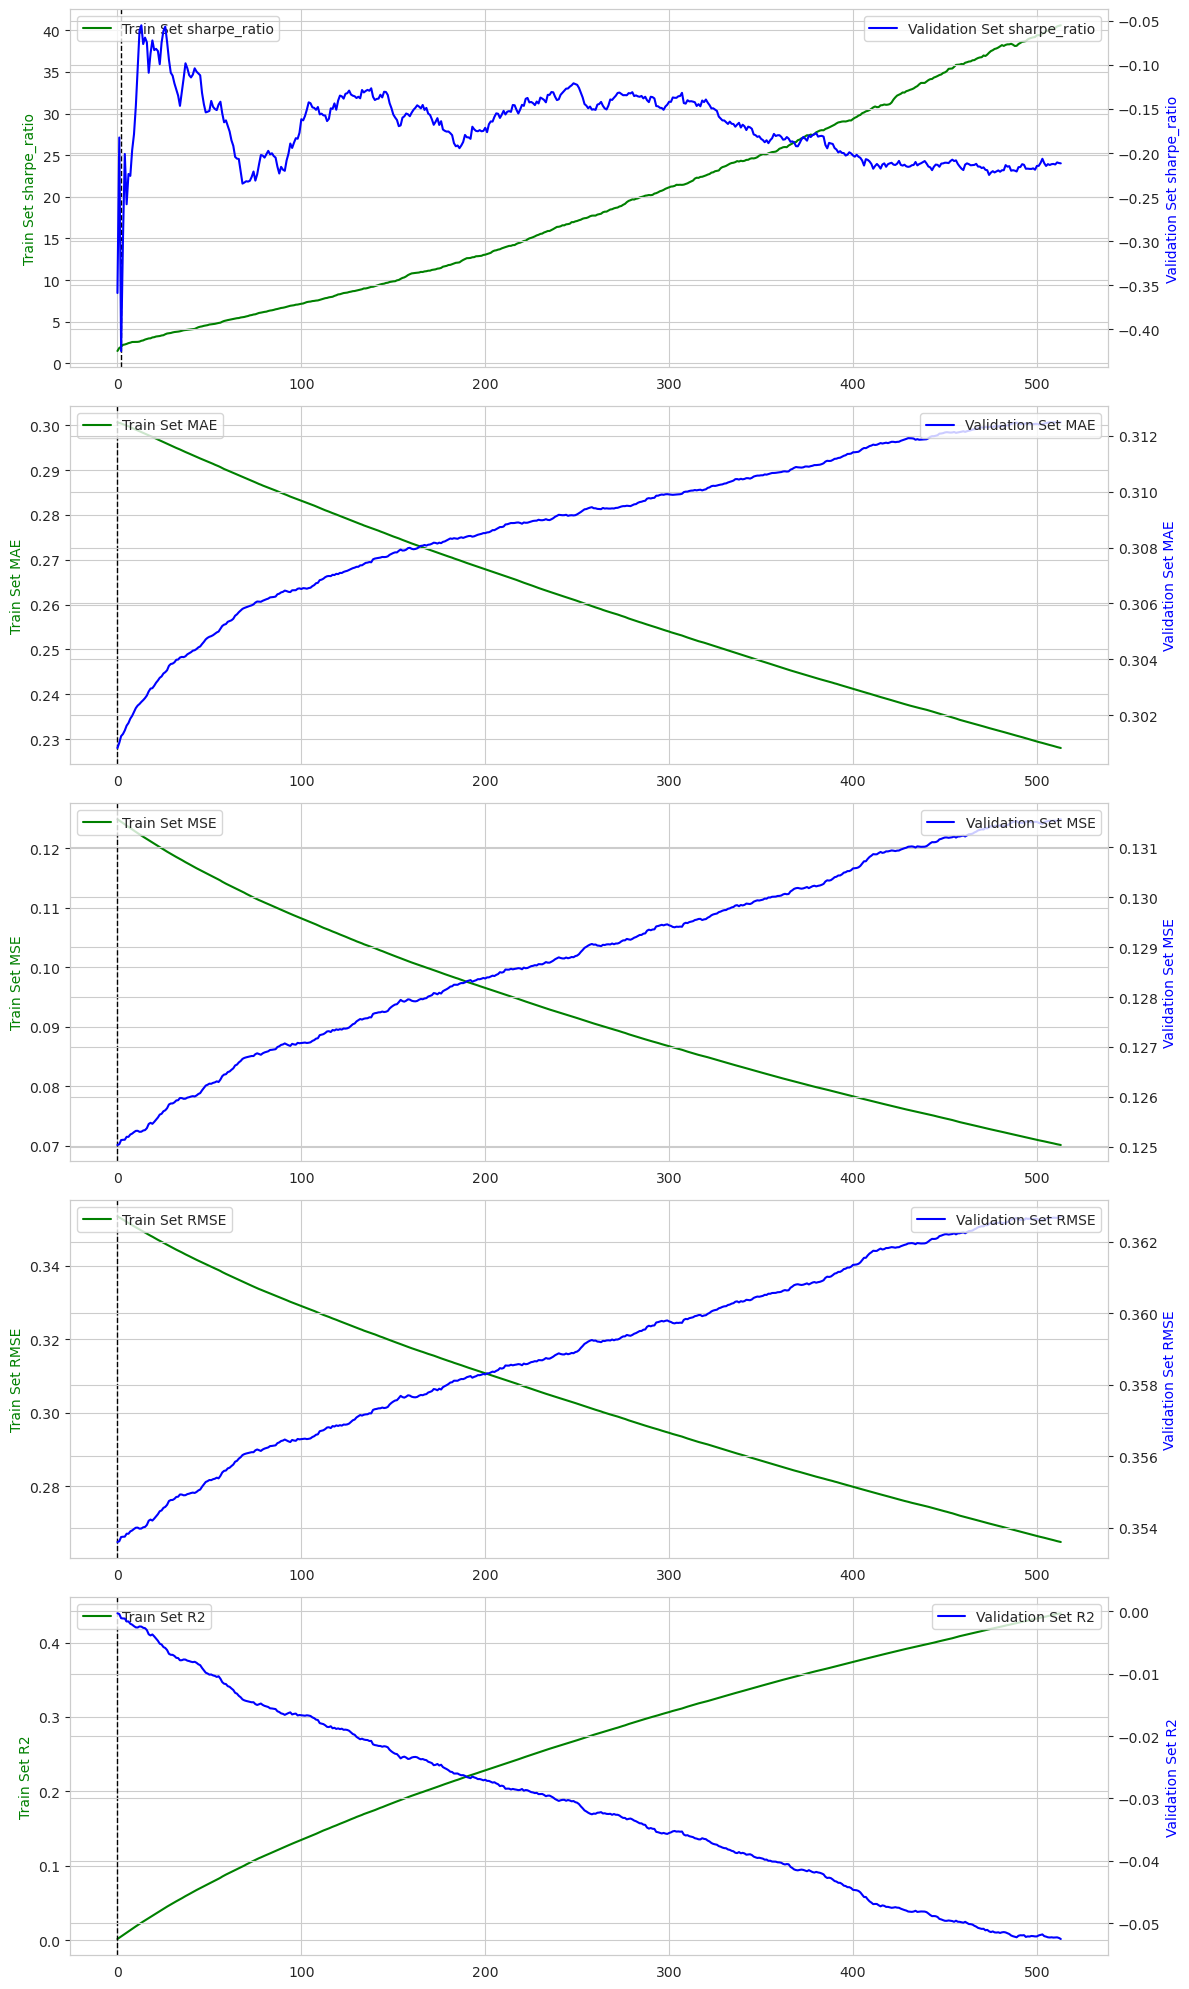

In [10]:
# Assuming evals_result contains MAE, MSE, RMSE, R2 as well
metrics = ['sharpe_ratio', 'MAE', 'MSE', 'RMSE', 'R2']

fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 4 * len(metrics)))

for ax, metric in zip(axes, metrics):
    cv_result = pd.DataFrame({'Train Set': evals_result['train'][metric], 
                              'Validation Set': evals_result['valid_0'][metric]})
    
    ax1 = ax
    ax2 = ax1.twinx()  # instantiate a second axes sharing the same x-axis
    
    ax1.plot(cv_result.index, cv_result['Train Set'], 'g-', label=f'Train Set {metric}')
    ax2.plot(cv_result.index, cv_result['Validation Set'], 'b-', label=f'Validation Set {metric}')
    
    ax1.set_ylabel(f'Train Set {metric}', color='g')
    ax2.set_ylabel(f'Validation Set {metric}', color='b')
    
    if metric != 'R2':
        ax1.axvline(cv_result['Validation Set'].idxmin(), c='k', ls='--', lw=1)
    else:
        ax1.axvline(cv_result['Validation Set'].idxmax(), c='k', ls='--', lw=1)

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [11]:
# # Extract cat_threshold from best_params
# cat_threshold = best_params.get('cat_threshold', 50)  # default to 50 if not in best_params

# Extract cat_threshold from best_params
cat_threshold = best_params.pop('cat_threshold', 50)  # default to 50 if not in best_params


# Determine the categorical columns based on cat_threshold
categoricals = [col for col in dataset.columns if dataset[col].nunique() < cat_threshold 
                and dataset[col].ge(0).all() and col.startswith("FEATURE_")]

# Create the training dataset
lgb_train_all = lgb.Dataset(data=dataset[features], label=dataset[label], 
                            categorical_feature=categoricals, free_raw_data=False)

best_params['force_col_wise'] = True
# Get the best iteration from your previous training
# Get the best iteration from your previous training
optimal_boosting_rounds = evals_result['valid_0']['sharpe_ratio'].index(max(evals_result['valid_0']['sharpe_ratio']))

if optimal_boosting_rounds == 0:
    optimal_boosting_rounds = 1
    print(optimal_boosting_rounds)

best_model = lgb.train(params=best_params,
                       train_set=lgb_train_all,
                       num_boost_round=optimal_boosting_rounds,  # Use the optimal number of rounds
                       feval=combined_eval_metrics,  # Updated feval
                       callbacks=[lgb.record_evaluation(evals_result)])

[LightGBM] [Info] Total Bins 96014
[LightGBM] [Info] Number of data points in the train set: 117250, number of used features: 541
[LightGBM] [Info] Start training from score 0.501501


In [12]:
from pathlib import Path

# Define the models folder path
models = Path("./models")

# Ensure the folder exists
models.mkdir(exist_ok=True)

# Ensure that dataset_key doesn't contain invalid characters like slashes
clean_dataset_key = dataset_key.replace("/", "_")

# Formulate the clean save path
save_path = models / f"{top}{clean_dataset_key}_best_model_{target}.txt"

# Try saving again
best_model.save_model(save_path)
print(f"Model saved to {save_path}")

Model saved to models/250_data_YEAR_20200930_20220802_best_model_TARGET_ret_fwd_01d.txt


#### Test on unseen data

In [13]:
from pathlib import Path
import pandas as pd
from utils import rank_stocks_and_quantile

top = 250  # parameters -> papermill
UNSEEN_KEY = '/data/YEAR_20220803_20230803'
UNSEEN_STORE = Path(f'data/{top}_unseen_dataset.h5')
with pd.HDFStore(UNSEEN_STORE) as store:
    test_data = store[UNSEEN_KEY]
    test_data = rank_stocks_and_quantile(test_data, TARGET_col=target)
    # print(store.keys())

In [14]:
test_features = test_data[features]
test_labels = test_data[label]

model_path = f"/home/sayem/Desktop/Project/{save_path}"
# Load the model
best_model = lgb.Booster(model_file=model_path)

y_pred = best_model.predict(test_features)

preds = test_labels.reset_index(name=\
    'actual').assign(predicted=y_pred).set_index(['date', 'ticker'])

# Rename columns to add 'feature_' prefix
cols_to_rename = ['open', 'high', 'low', 'close', 'volume']
new_col_names = ["FEATURE_" + col for col in cols_to_rename]
rename_dict = dict(zip(cols_to_rename, new_col_names))

test_data_renamed = test_data.rename(columns=rename_dict)

# Using the 'merge' method to join on MultiIndex levels 'date' and 'ticker'
preds = preds.reset_index().merge(test_data_renamed[new_col_names].reset_index(), 
                                  on=['ticker', 'date'], 
                                  how='left')

### Only select columns of interest
preds = preds[['date', 'ticker', 'actual', 'predicted'] \
    + new_col_names].set_index(['ticker', 'date'])


In [15]:
preds.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 66002 entries, ('AA', Timestamp('2022-08-03 00:00:00+0000', tz='UTC')) to ('ZTS', Timestamp('2023-08-03 00:00:00+0000', tz='UTC'))
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   actual          66002 non-null  float64
 1   predicted       66002 non-null  float64
 2   FEATURE_open    66002 non-null  float32
 3   FEATURE_high    66002 non-null  float32
 4   FEATURE_low     66002 non-null  float32
 5   FEATURE_close   66002 non-null  float32
 6   FEATURE_volume  66002 non-null  float64
dtypes: float32(4), float64(3)
memory usage: 2.8+ MB


Dropped 36.1% entries from factor data: 4.0% in forward returns computation and 32.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 60.0%, not exceeded: OK!

Sharpe Ratios:
 1D     4.333202
5D     1.732614
10D    1.238222
dtype: float64
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,0.00,0.25,0.088791,0.119646,12321,30.611941
2.0,0.25,0.50,0.401146,0.122242,9165,22.770752
3.0,0.50,0.75,0.645095,0.123384,6239,15.501006
4.0,0.75,0.75,0.750000,0.000000,4537,11.272330
5.0,1.00,1.00,1.000000,0.000000,7987,19.843971


Returns Analysis


,1D,5D,10D
Ann. alpha,58.410,1.264,0.514
beta,0.012,0.035,0.045
Mean Period Wise Return Top Quantile (bps),212.222,44.444,23.343
Mean Period Wise Return Bottom Quantile (bps),-173.783,-33.988,-16.611
Mean Period Wise Spread (bps),386.005,78.396,39.917


<Figure size 640x480 with 0 Axes>

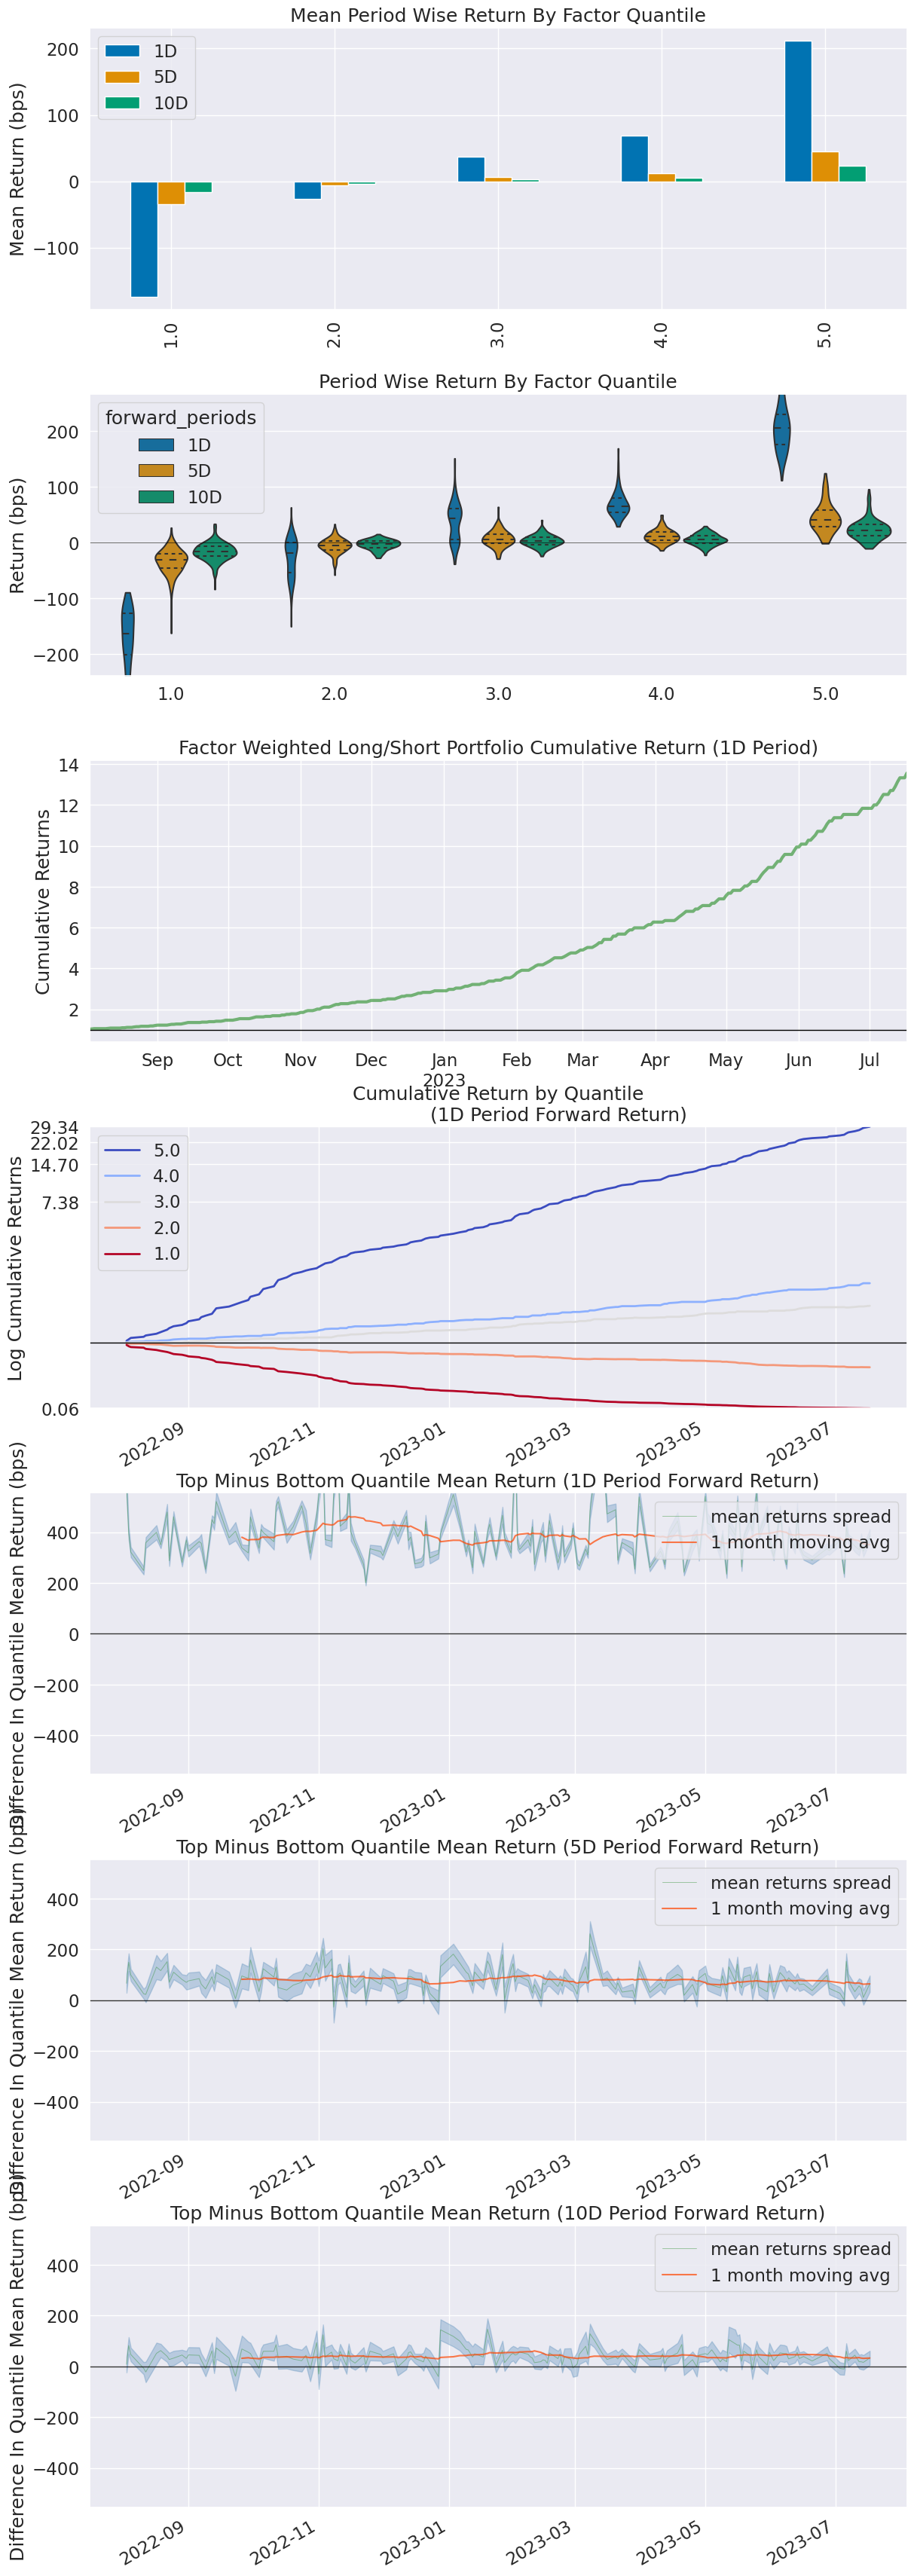

Information Analysis


,1D,5D,10D
IC Mean,0.976,0.380,0.272
IC Std.,0.006,0.170,0.182
Risk-Adjusted IC,169.811,2.237,1.494
t-stat(IC),NaN,NaN,NaN
p-value(IC),NaN,NaN,NaN
IC Skew,NaN,NaN,NaN
IC Kurtosis,NaN,NaN,NaN


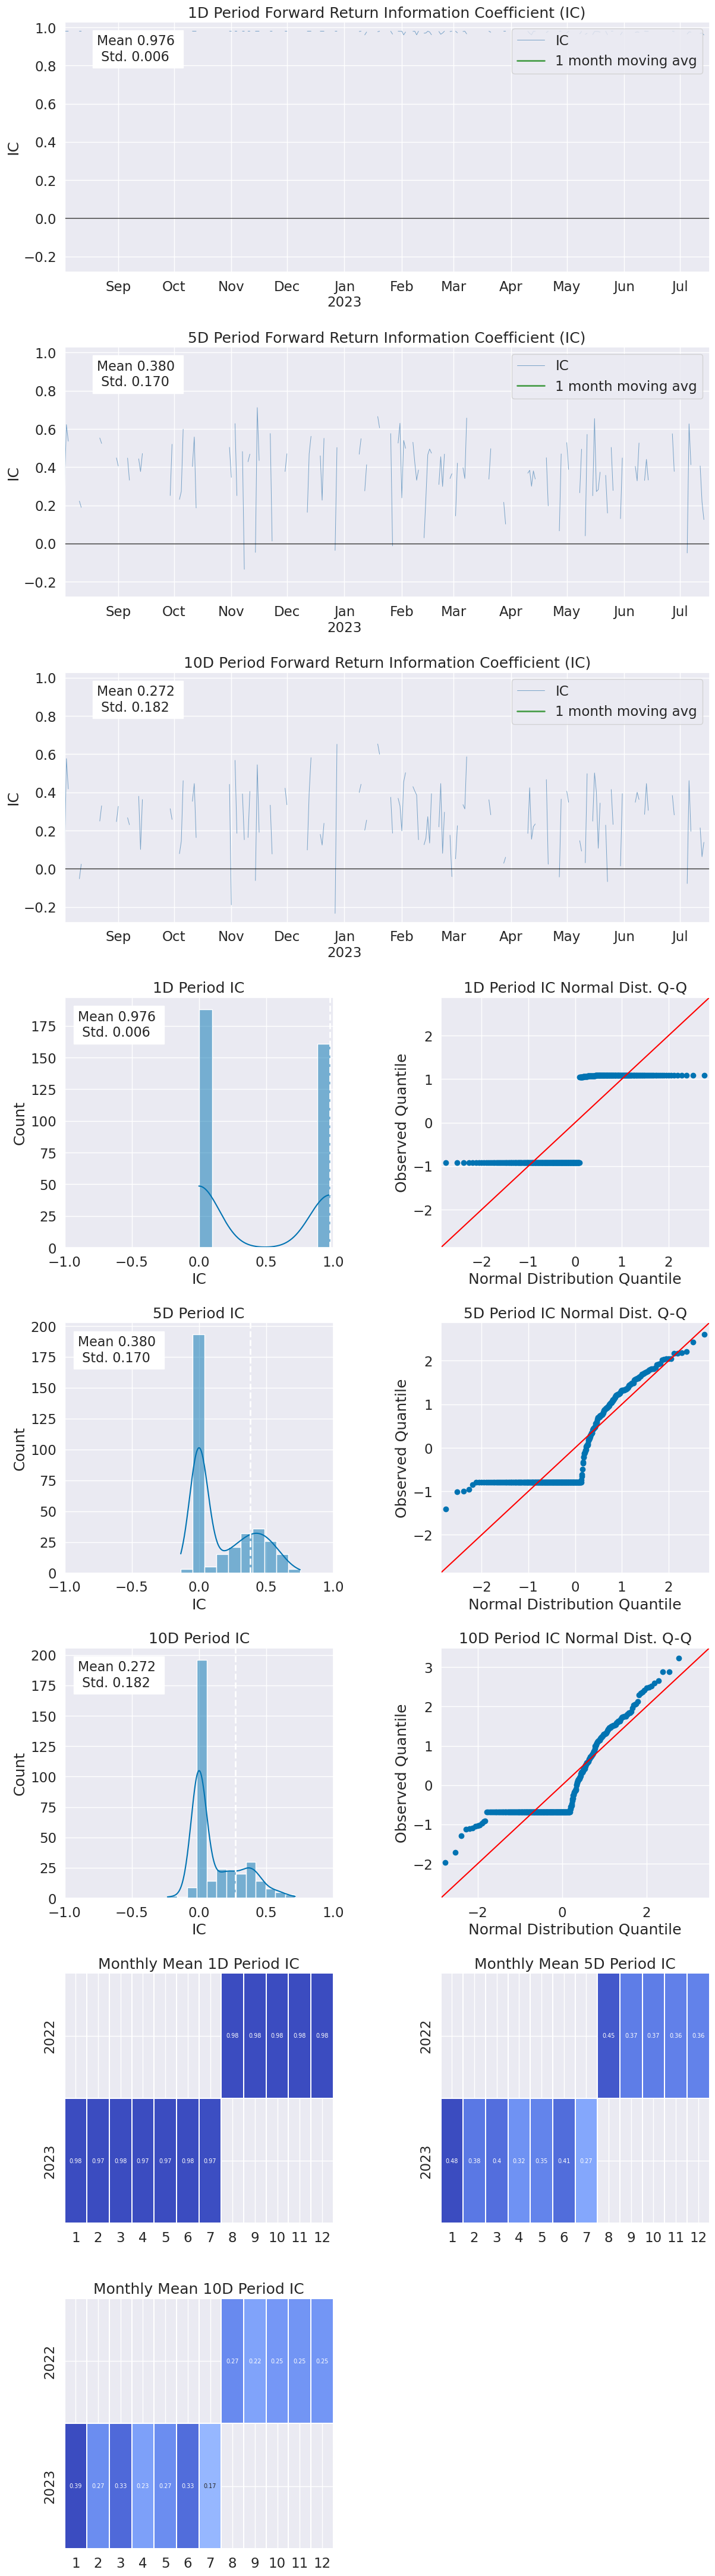

Turnover Analysis


,1D,5D,10D
Quantile 1.0 Mean Turnover,0.699,0.671,0.711
Quantile 2.0 Mean Turnover,0.759,0.759,0.763
Quantile 3.0 Mean Turnover,0.781,0.758,0.769
Quantile 4.0 Mean Turnover,0.811,0.786,0.779
Quantile 5.0 Mean Turnover,0.769,0.774,0.776


,1D,5D,10D
Mean Factor Rank Autocorrelation,-0.016,-0.011,0.025


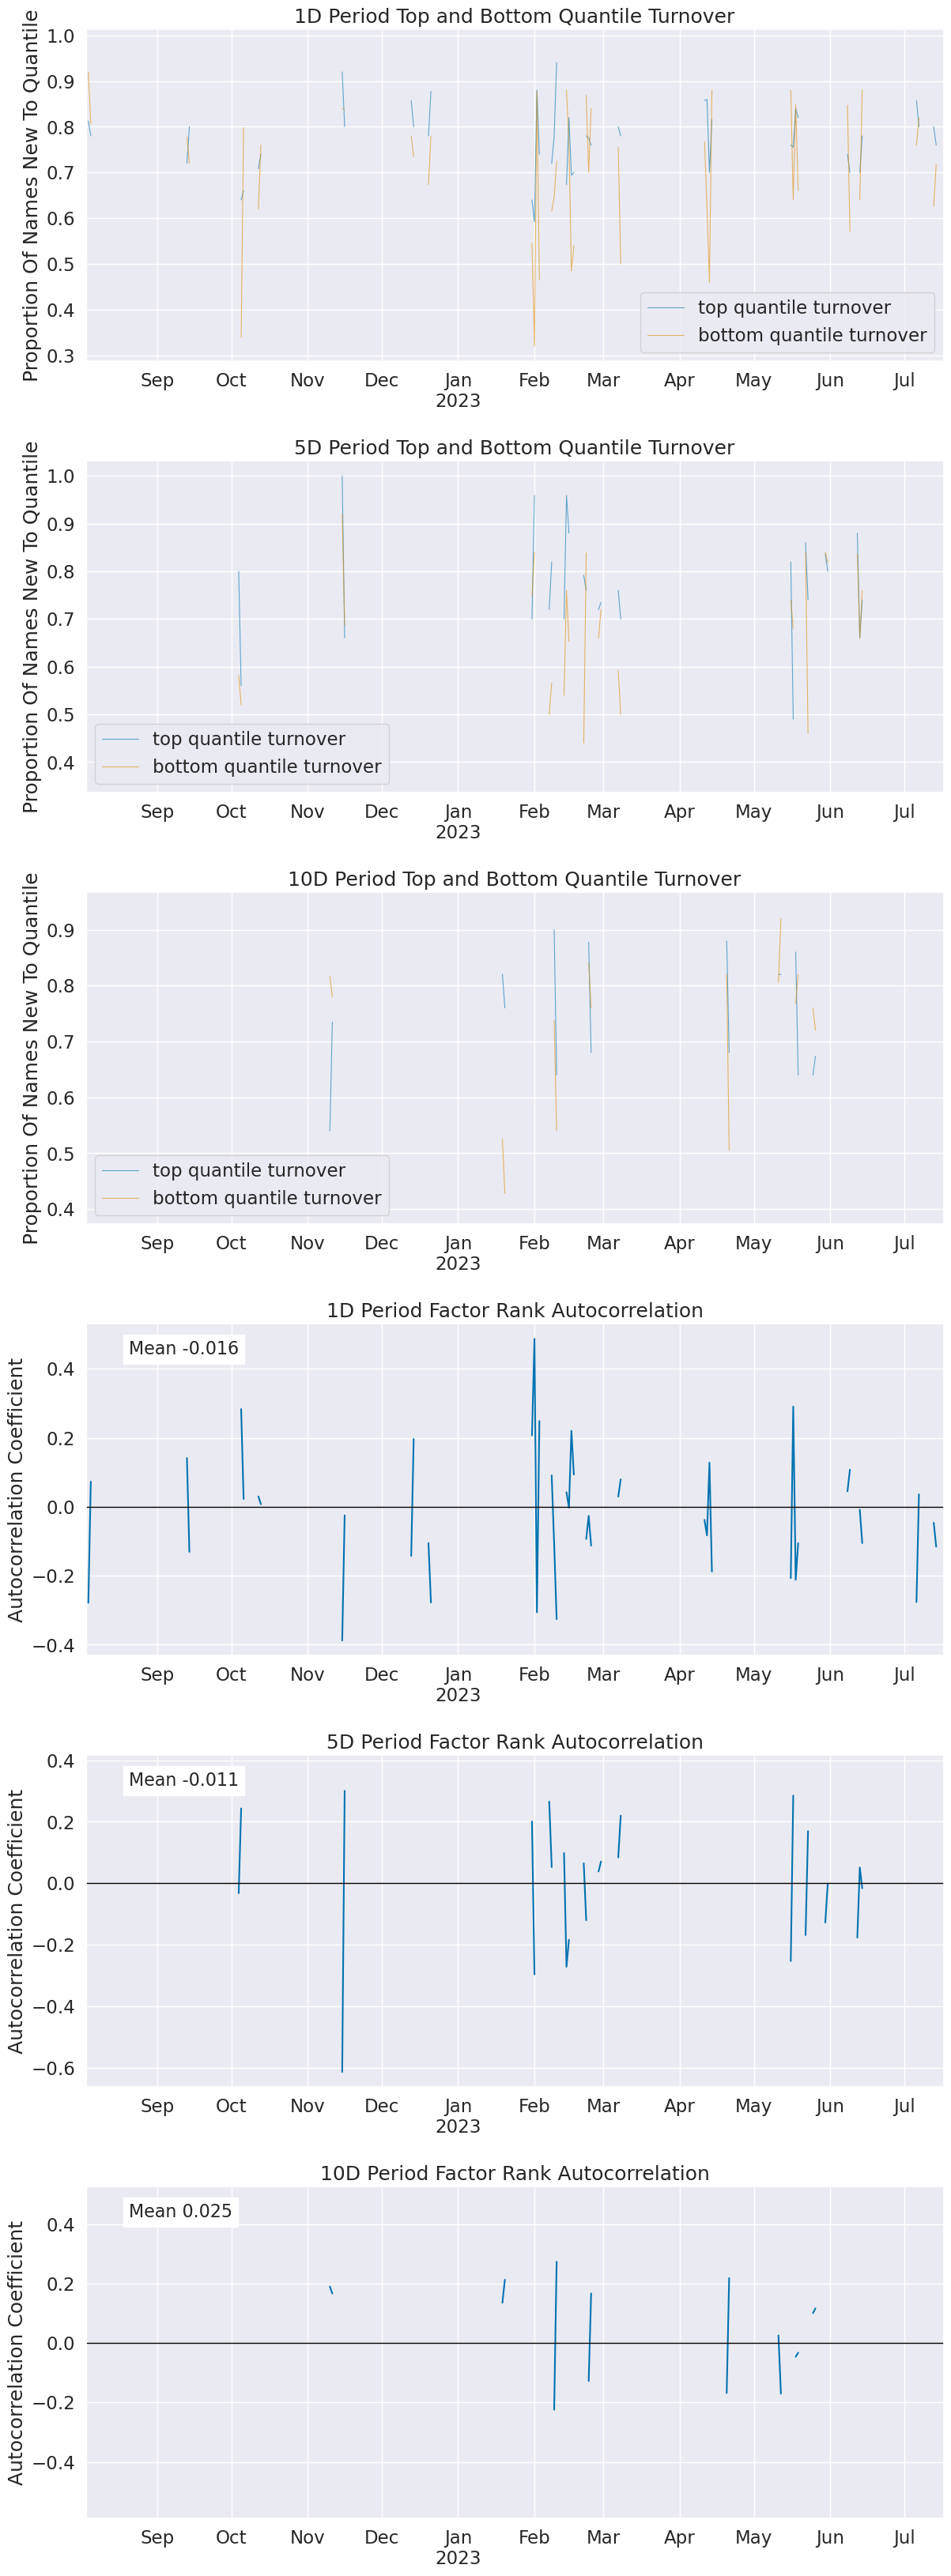

In [16]:
import pandas as pd
import alphalens as al

def generate_alphalens_tearsheet(df: pd.DataFrame, label_col: str, price_col: str) -> None:
    """
    Generate the Alphalens full tearsheet given the input dataframe, 
    label column, and price data column.
    """
    # Extract the factor and trade_prices series
    factor = df[label_col]
    trade_prices = df[price_col]
    
    # Remove duplicated indices from factor and trade_prices
    factor = factor[~factor.index.duplicated(keep='first')]
    trade_prices = trade_prices[~trade_prices.index.duplicated(keep='first')]
    
    # Convert the trade_prices series into unstacked format
    trade_prices_unstacked = trade_prices.unstack(level='ticker')
    
    # Ensure the factor's DatetimeIndex level has the same timezone as trade_prices_unstacked
    if isinstance(factor.index, pd.MultiIndex):
        level_0 = factor.index.get_level_values(0)
        if hasattr(level_0, 'tz') and level_0.tz is not None:
            if level_0.tz != trade_prices_unstacked.index.tz:
                factor.index.set_levels(level_0.tz_convert(trade_prices_unstacked.index.tz), \
                    level=0, inplace=True)
        factor = factor.swaplevel().sort_index()
    else:
        if hasattr(factor.index, 'tz') and factor.index.tz is not None:
            if factor.index.tz != trade_prices_unstacked.index.tz:
                factor.index = factor.index.tz_convert(trade_prices_unstacked.index.tz)

    # Create the factor_data dataframe with forward returns
    alphalen_analysis = al.utils.get_clean_factor_and_forward_returns(
        factor=factor,
        prices=trade_prices_unstacked,
        periods=[1, 5, 10],
        max_loss=0.6
    )

    factor_returns = al.performance.factor_returns(alphalen_analysis)
    sharpe_ratios = factor_returns.mean() / factor_returns.std()

    print("\nSharpe Ratios:\n", sharpe_ratios)
    alphalen_analysis = alphalen_analysis[~alphalen_analysis.index.duplicated(keep='first')]
    alphalen_analysis = alphalen_analysis.groupby(level=[0, 1]).mean()
    return alphalen_analysis

target = 'actual'
alphalens_analysis = generate_alphalens_tearsheet(preds, \
    label_col=target, price_col='FEATURE_close')

import alphalens as al
al.tears.create_full_tear_sheet(alphalens_analysis)

In [17]:
# import pandas as pd
# import alphalens as al

# def generate_alphalens_tearsheet(df: pd.DataFrame, \
#     label_col: str, price_col: str) -> None:
#     """
#     Generate the Alphalens full tearsheet given the input dataframe, 
#     label column, and price data column.
#     """
#     # Extract the factor and trade_prices series
#     factor = df[label_col]
#     trade_prices = df[price_col]
    
#     # Handle duplicate indices in trade_prices
#     trade_prices = trade_prices[~trade_prices.index.duplicated(keep='first')]
    
#     # Convert the trade_prices series into unstacked format
#     trade_prices_unstacked = trade_prices.unstack(level='ticker')
    
#     # Ensure the factor's DatetimeIndex level has the same timezone as trade_prices_unstacked
#     if isinstance(factor.index, pd.MultiIndex):
#         level_0 = factor.index.get_level_values(0)
#         if hasattr(level_0, 'tz') and level_0.tz is not None:
#             if level_0.tz != trade_prices_unstacked.index.tz:
#                 factor.index.set_levels(level_0.tz_convert(trade_prices_unstacked.index.tz), level=0, inplace=True)
#         factor = factor.swaplevel().sort_index()
#     else:
#         if hasattr(factor.index, 'tz') and factor.index.tz is not None:
#             if factor.index.tz != trade_prices_unstacked.index.tz:
#                 factor.index = factor.index.tz_convert(trade_prices_unstacked.index.tz)

#     # Create the factor_data dataframe with forward returns
#     alphalen_analysis = al.utils.get_clean_factor_and_forward_returns(
#         factor=factor,
#         prices=trade_prices_unstacked,
#         periods=[1, 5, 10],
#         max_loss=0.5
#     )

#     factor_returns = al.performance.factor_returns(alphalen_analysis)
#     sharpe_ratios = factor_returns.mean() / factor_returns.std()

#     print("\nSharpe Ratios:\n", sharpe_ratios)
#     alphalen_analysis = alphalen_analysis[~alphalen_analysis.index.duplicated(keep='first')]
#     alphalen_analysis = alphalen_analysis.groupby(level=[0, 1]).mean()
#     return alphalen_analysis

# target = 'predicted'
# alphalens_analysis = generate_alphalens_tearsheet(preds, label_col=target, price_col='FEATURE_close')

# import alphalens as al
# al.tears.create_full_tear_sheet(alphalens_analysis)

In [18]:
preds

,,actual,predicted,FEATURE_open,FEATURE_high,FEATURE_low,FEATURE_close,FEATURE_volume
ticker,date,,,,,,,
AA,2022-08-03 00:00:00+00:00,0.00,0.507037,48.448700,48.631500,47.298901,48.269600,4.403141e+06
AAL,2022-08-03 00:00:00+00:00,1.00,0.491800,14.200000,14.700000,14.150000,14.630000,2.836655e+07
AAPL,2022-08-03 00:00:00+00:00,0.50,0.504215,160.350998,166.082993,160.261002,165.625000,8.275915e+07
ABBV,2022-08-03 00:00:00+00:00,0.00,0.502044,140.292007,141.578995,139.227997,139.778000,5.529937e+06
ABT,2022-08-03 00:00:00+00:00,0.50,0.499292,108.598000,109.454002,107.762001,109.095001,3.884412e+06
...,...,...,...,...,...,...,...,...
WYNN,2023-08-03 00:00:00+00:00,0.00,0.504676,104.250000,106.849998,102.129997,105.610001,1.614293e+06
X,2023-08-03 00:00:00+00:00,0.50,0.500983,24.360001,24.865000,23.750000,24.260000,9.083687e+06
XOM,2023-08-03 00:00:00+00:00,0.75,0.497742,105.889999,107.879997,105.300003,107.120003,1.628311e+07


In [19]:
def daily_spearman(group):
    return spearmanr(group['actual'], group['predicted'])[0]

daily_correlations = preds.groupby('date').apply(daily_spearman)

In [20]:
daily_correlations

date
2022-08-03 00:00:00+00:00   -0.227186
2022-08-04 00:00:00+00:00    0.199410
2022-08-05 00:00:00+00:00   -0.020277
2022-08-08 00:00:00+00:00    0.120799
2022-08-09 00:00:00+00:00    0.002905
2022-08-10 00:00:00+00:00    0.036429
2022-08-11 00:00:00+00:00   -0.005875
2022-08-12 00:00:00+00:00    0.032304
2022-08-15 00:00:00+00:00    0.023304
2022-08-16 00:00:00+00:00    0.180253
2022-08-17 00:00:00+00:00   -0.111020
2022-08-18 00:00:00+00:00    0.272028
2022-08-19 00:00:00+00:00    0.101796
2022-08-22 00:00:00+00:00    0.039455
2022-08-23 00:00:00+00:00   -0.115363
2022-08-24 00:00:00+00:00   -0.137080
2022-08-25 00:00:00+00:00    0.300493
2022-08-26 00:00:00+00:00   -0.039182
2022-08-29 00:00:00+00:00    0.070436
2022-08-30 00:00:00+00:00    0.015501
2022-08-31 00:00:00+00:00   -0.006504
2022-09-01 00:00:00+00:00    0.095965
2022-09-02 00:00:00+00:00   -0.070897
2022-09-06 00:00:00+00:00   -0.216835
2022-09-07 00:00:00+00:00   -0.020271
2022-09-08 00:00:00+00:00   -0.050997
2022-09

In [21]:
daily_correlations.mean()

0.030958131487255784

In [22]:
daily_correlations.std()

0.11047710889897978

In [23]:
# Calculate the mean of daily correlations
mean_daily_correlation = daily_correlations.mean()

# Calculate Sharpe ratio for each date
fold_sharpe_ratio = papermill_fold_scores = daily_correlations / daily_correlations.std()

papermill_fold_scores_df = papermill_fold_scores.to_frame()
papermill_fold_scores_df.columns = papermill_fold_scores_df.columns.astype(str)
sb.glue("papermill_era_scores", papermill_fold_scores_df, display=True)

,0
date,
2022-08-03 00:00:00+00:00,-2.056405
2022-08-04 00:00:00+00:00,1.804993
2022-08-05 00:00:00+00:00,-0.183544
2022-08-08 00:00:00+00:00,1.093430
2022-08-09 00:00:00+00:00,0.026293
2022-08-10 00:00:00+00:00,0.329740
2022-08-11 00:00:00+00:00,-0.053177
2022-08-12 00:00:00+00:00,0.292407
2022-08-15 00:00:00+00:00,0.210939


In [24]:
# import matplotlib.pyplot as plt

# # Create a list of colors based on the sign of the Sharpe Ratios
# colors = ['blue' if value > 0 else 'red' for value in fold_sharpe_ratio]

# plt.figure(figsize=(12,6))
# fold_sharpe_ratio.plot(kind='bar', color=colors)
# plt.title('Daily Sharpe Ratios')
# plt.xlabel('Date')
# plt.ylabel('Sharpe Ratio')
# plt.grid(axis='y')
# plt.tight_layout()
# plt.axhline(y=0, color='black', linestyle='-')  # Here's where we add the horizontal line at y=0
# plt.xticks(rotation=45)  # rotates the x-axis labels for better visibility
# plt.show()

In [25]:
# plot_dir = Path("plots")
# plot_dir.mkdir(exist_ok=True)
# plot_path = plot_dir / f"sharpe_ratios_{key}.png"
# plt.savefig(plot_path)
# plt.close()

# papermill_plot_path_str = str(plot_path)  # Convert to string
# sb.glue("papermill_plot_path", papermill_plot_path_str, display=True)  # Glue the string

In [26]:
lr_r, lr_p = spearmanr(preds.actual, preds.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.8%})')

# Return the Information Coefficient and its p-value
information_coefficient = lr_r
p_value = lr_p

# information_coefficient = papermill_information_coefficient, p_value = papermill_p_value
sb.glue("information_coefficient", information_coefficient, display=True)
sb.glue("p_value", p_value, display=True)

Information Coefficient (overall): 3.151% (p-value: 0.00000000%)


0.03151366098364448

5.58762390441783e-16

In [27]:
# papermill_plot_path_str = str(plot_path)  # Convert to string
# sb.glue("papermill_plot_path", papermill_plot_path_str)  # Glue the string

# sb.glue("information_coefficient", information_coefficient)
# sb.glue("p_value", p_value)